# Introduction

This lab enhancement focuses on improve K-Means clustering, reduce the dimension by introducing principal component analysis (PCA), and evaluate its effectiveness in student achievement data. The goal is to optimize the clustering process, reduce feature redundancy, ensure meaningful group separation, and verify the clustering results through various metrics.

In [1]:
## import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import KMeans,  DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# 1.0 Data Exploration

We examine the data types and summary statistics to understand their structure.

In [2]:
data = pd.read_csv('StudentsPerformance.csv')

In [3]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


This dataset contain 5 categorical features and 3 numerical features

# 2.0 Exploratory Data Analysis (EDA)

To gain deeper insights into the dataset, we perform an Exploratory Data Analysis (EDA). This involves visualizing the distributions of student scores in subjects like Mathematics, Reading, and Writing. By using histograms and bar plots, we can observe patterns and trends within the data. Additionally, categorical variables such as Gender, Parental Education, and Lunch Type are analyzed to understand their impact on student performance. 

## Encode Categorical Variables

In [6]:
all_categorical_cols = ['gender', 'lunch', 'test preparation course', 'race/ethnicity', 'parental level of education']

# Apply Label Encoding to these columns
label_encoder = LabelEncoder()
for col in all_categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Display dataset after encoding
data.head(17)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
5,0,1,0,1,1,71,83,78
6,0,1,4,1,0,88,95,92
7,1,1,4,0,1,40,43,39
8,1,3,2,0,0,64,64,67
9,0,1,2,0,1,38,60,50


- Gender: {0 = 'female', 1 = 'male'}
  
- Race/Ethnicity: {0 = 'group A', 1 = 'group B', 2 = 'group C', 3 = 'group D', 4 = 'group E'}

- Parental Level of Education: {0='associate's degree', 1='bachelor's degree', 2='high school', 3='master's degree', 4='some college',5='some high school'}

- Lunch: {0='free/reduced', 1='standard'}

- test Preparation Course: {0='none', 1='completed'}

## Numerical Features Distributions

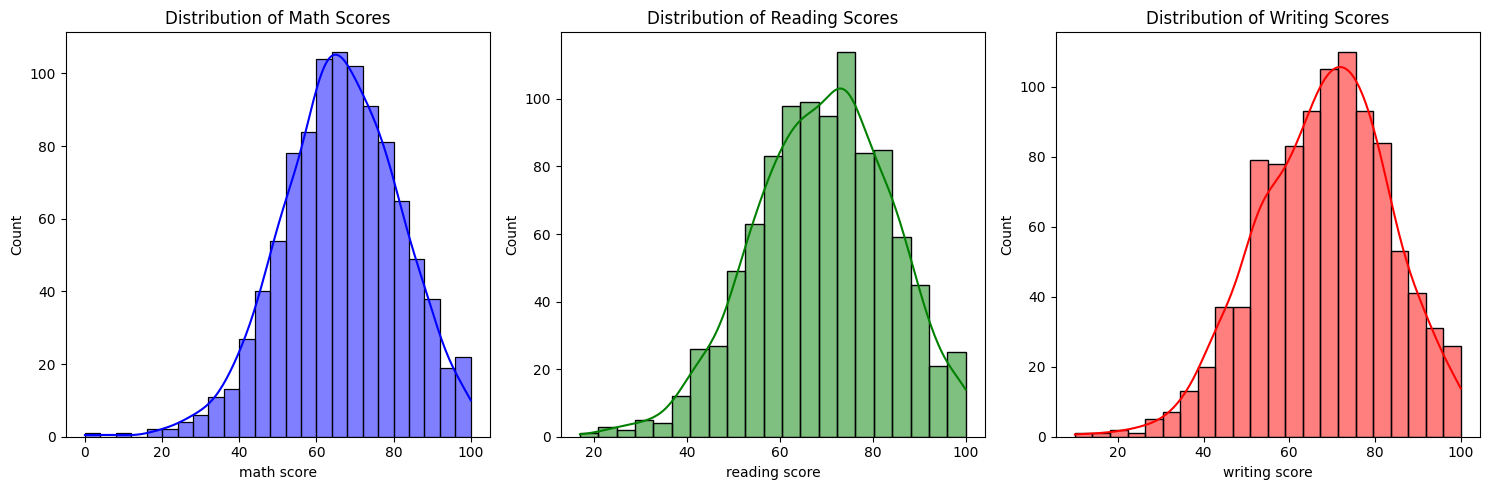

In [7]:
# Visualizing distributions of student scores
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data['math score'], kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Math Scores")

sns.histplot(data['reading score'], kde=True, ax=axes[1], color='green')
axes[1].set_title("Distribution of Reading Scores")

sns.histplot(data['writing score'], kde=True, ax=axes[2], color='red')
axes[2].set_title("Distribution of Writing Scores")

plt.tight_layout()
plt.show()

1. The first KDE plots and histograms show that the majority of students scored around 0.6, with over 125 students scoring in this range. The distribution is slightly right-skewed, meaning that high scores are more common than low scores. The majority of students scored between 0.5 and 0.8, indicating a moderate distribution of scores. A small number of students scored significantly lower, and only a very small number of students scored close to 0.0. The right-hand tail extends towards 1.0, suggesting that some students achieved high scores, but this was less common.

2.  The second KDE plots and histograms shows that the majority of students scored around 0.7, with over 125 students scoring in this range. The distribution is slightly skewed to the left, meaning that low scores are more common than high scores. The majority of students scored between 0.4 and 0.8, indicating a moderate distribution of scores. 

3.  The third KDE plots and histograms reveals that student performance is concentrated around 0.7, where the highest density occurs. The distribution shows a slight left skew, indicating that while most students scored in the mid-to-high range, a few had significantly lower scores. 

## Categorical Data Distributions

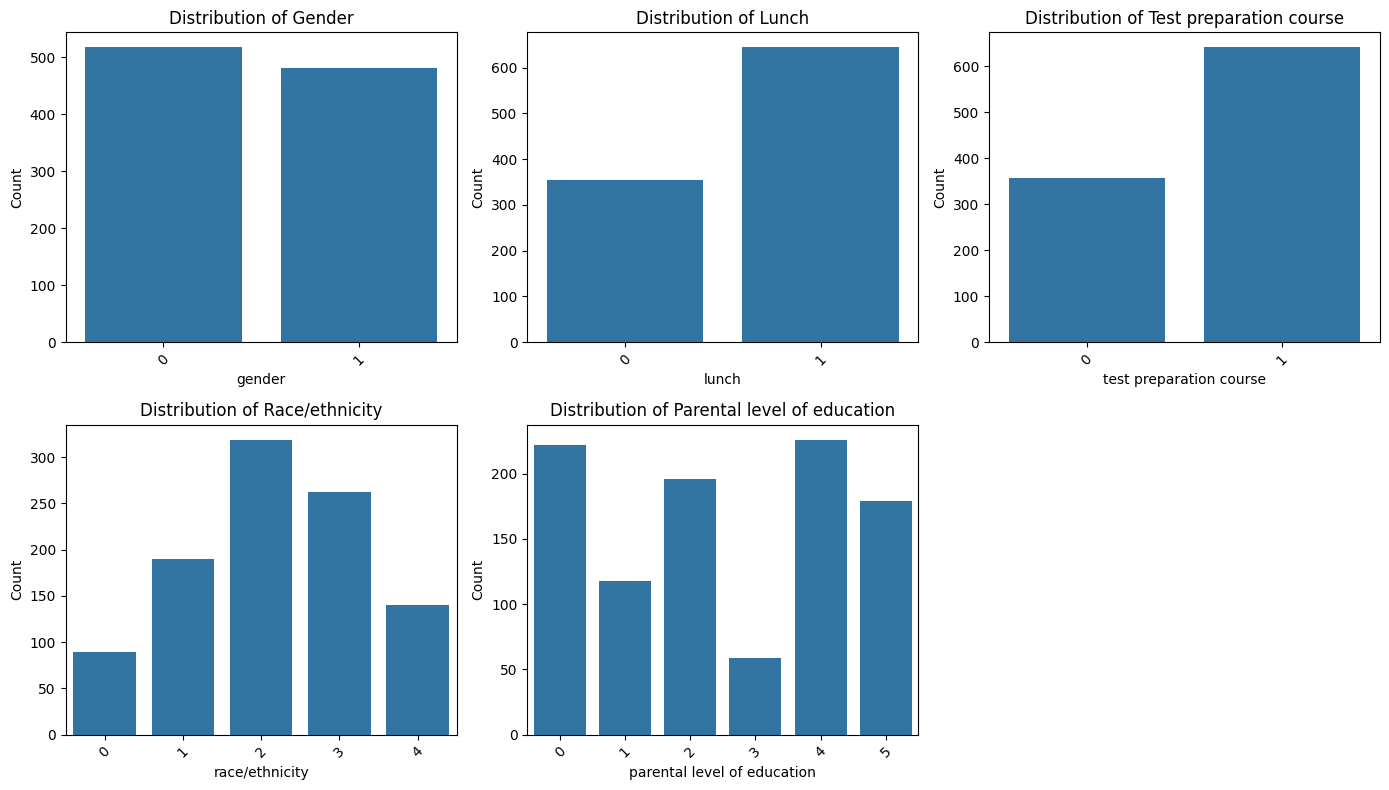

In [8]:
# Define number of columns for the plot grid

all_categorical_cols = ['gender', 'lunch', 'test preparation course', 'race/ethnicity', 'parental level of education']
num_cols = 3  # 3 subplots per row
num_rows = (len(all_categorical_cols) + num_cols - 1) // num_cols  # Calculate required rows

plt.figure(figsize=(14, 4 * num_rows))

for i, col in enumerate(all_categorical_cols, 1):  # Loop through all categorical columns
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x=data[col])
    plt.title(f"Distribution of {col.capitalize()}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. In terms of gender distribution, the proportion of male and female students is more or less balanced. However, there are slightly more females (0) than males (1) in the data set.

2. The distribution of lunch shows that the majority of students have access to standard lunches (1), while a small percentage of students fall into the free/reduced lunch (0) category. This indicates that most students do not rely on free/reduced meals before the test.

3. The distribution of test preparation courcse shows that more students have attended (1) test preparation courcse than (0) compared to those who have not attended a test preparation courcse. This indicates that a significant number of students made extra preparations before the exam.

4. The racial/ethnic distribution includes five groups: Group C (2) has the largest number of students, followed by Group D (3). Group A (0) has the smallest number of students, indicating that some racial/ethnic groups are more unusual than others and may be racial minorities.

5. The distribution of parental education shows that students come from a variety of educational backgrounds. The largest number of students had parents with some college education (4) or an associate's degree (0). Conversely, the lowest number of students had parents with a master's degree (3). This difference suggests that the level of parental education varies greatly among students.

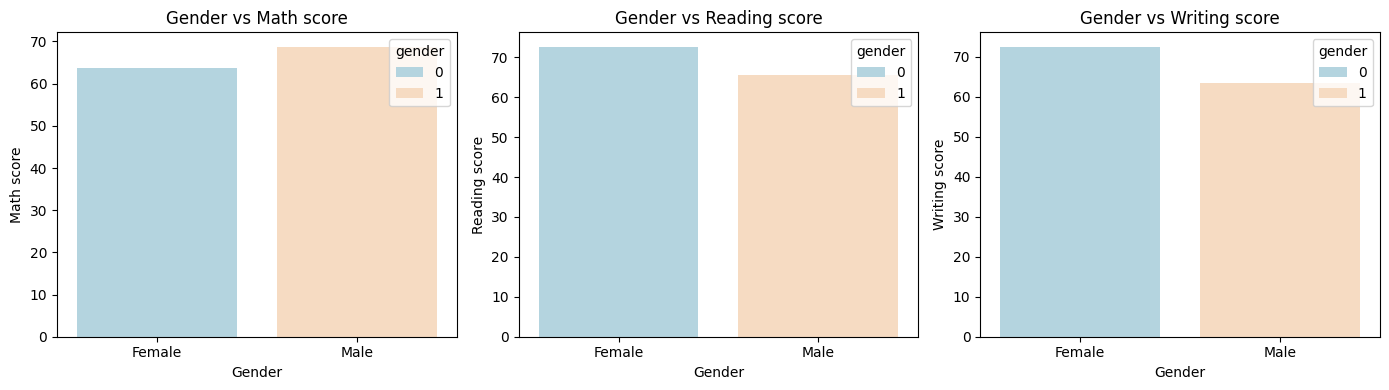

In [9]:
score_cols = ['math score', 'reading score', 'writing score']

num_cols = 3  # Number of plots per row
num_rows = (len(score_cols) + num_cols - 1) // num_cols  # Auto-adjust rows

plt.figure(figsize=(14, num_rows * 4))

for i, col in enumerate(score_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.barplot(x='gender', y=col, data=data, hue='gender', palette=["lightblue", "peachpuff"], errorbar=None)
    plt.xticks(ticks=[0, 1], labels=["Female", "Male"])
    plt.title(f"Gender vs {col.capitalize()}", fontsize=12)
    plt.xlabel("Gender", fontsize=10)
    plt.ylabel(col.capitalize(), fontsize=10)

plt.tight_layout()
plt.show()

1. The first bor plot shows the relationship between gender and math scores. Male(1) have slightly higher average math scores than female(0). This shows that male tend to do slightly better in math, although the difference is not very large.

2. The second bar plot the relationship between gender and reading scores. Female have higher average reading scores compared to male. The difference in reading scores is more pronounced than the difference in math scores, indicating that female generally have better reading comprehension and literacy skills.

3. The third graph represents the relationship between gender and writing scores. Female also have better writing scores than male. This gap is significant and shows that female tend to have stronger writing skills. This trend is consistent with research showing that female usually perform better in language-related subjects.

In all subjects, female consistently scored higher than male, suggesting a possible upward trend in female academic performance in this dataset.

## Correlation Analysis

The heatmap shows the correlation between all the features

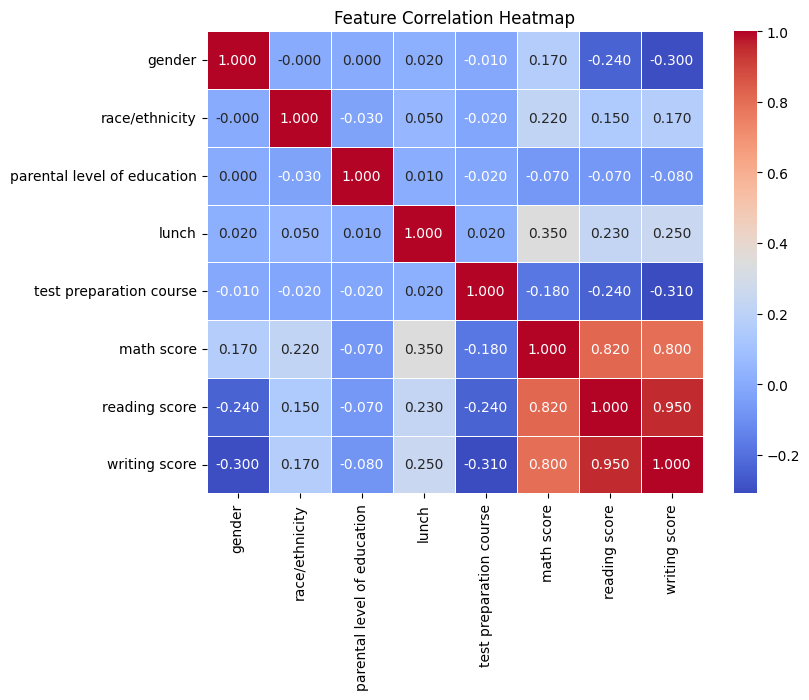

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr().round(2), annot=True, fmt=".3f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

1. Math Score and Reading Score: There is a strong positive correlation of 0.820 between math scores and reading scores. This suggests that students who excel in math are likely to also excel in reading. It can be inferred that proficiency in one subject area may facilitate or enhance performance in another, reflecting possible overlap in skills or study habits.

2. Reading Score and Writing Score: The correlation between reading scores and writing scores was very strong at 0.950. This suggests that students with higher reading scores will also have higher writing scores. This may imply that stronger reading skills may affect students' writing skills as both subjects usually require similar ability to comprehend and use language.

3. Math Score and Writing Score: There was a significant correlation of 0.800 between math scores and writing scores. This suggests that students who are good at mathematical reasoning are likely to develop strong writing skills. Logical thinking and organized problem solving in mathematics may contribute to clearer, more organized writing.

4. Lunch: Lunch was moderately positively correlated with academic performance (math, reading, and writing scores). Students who ate a standard lunch tended to perform better in math, reading and writing. This implies that proper nutrition may have a positive impact on learning and cognitive skills, which can lead to improved academic performance.

5. Test Preparation Course: The correlation between test preparation courses and scores was relatively low, at -0.180 for math scores and -0.310 for writing scores.This suggests a weak to moderate negative correlation, suggesting that students in this dataset who took a test preparation course may not have significantly improved their math or writing scores compared to students who did not take the test.

6. Parental Level of Education: Parents' level of education is not significantly related to students' academic performance (math, reading, and writing scores). This suggests that student's performance may be less dependent on their parents' educational background.

# 3.0 Feature Engineering

In [11]:
# Compute average score for each student
data['average_score'] = (data['math score'] + data['reading score'] + data['writing score']) / 3

# Display first few rows with the new feature
data[['math score', 'reading score', 'writing score', 'average_score']].head()

,math score,reading score,writing score,average_score
0,72,72,74,72.666667
1,69,90,88,82.333333
2,90,95,93,92.666667
3,47,57,44,49.333333
4,76,78,75,76.333333


We calculate the overall grade by taking the average of the grades for mathematics, reading and writing. This new feature provides a more comprehensive picture of students' academic performance.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Define numerical columns to scale
numerical_cols= ['math score', 'reading score', 'writing score', 'average_score']

# Apply Min-Max Scaling
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display scaled values
data[numerical_cols].head()

,math score,reading score,writing score,average_score
0,0.72,0.662651,0.711111,0.699634
1,0.69,0.879518,0.866667,0.805861
2,0.90,0.939759,0.922222,0.919414
3,0.47,0.481928,0.377778,0.443223
4,0.76,0.734940,0.722222,0.739927


To ensure consistency across numerical variables, we apply Min-Max Scaling, which standardizes the data within a fixed range.

## Boxplot between Categorical Features with Average Scores

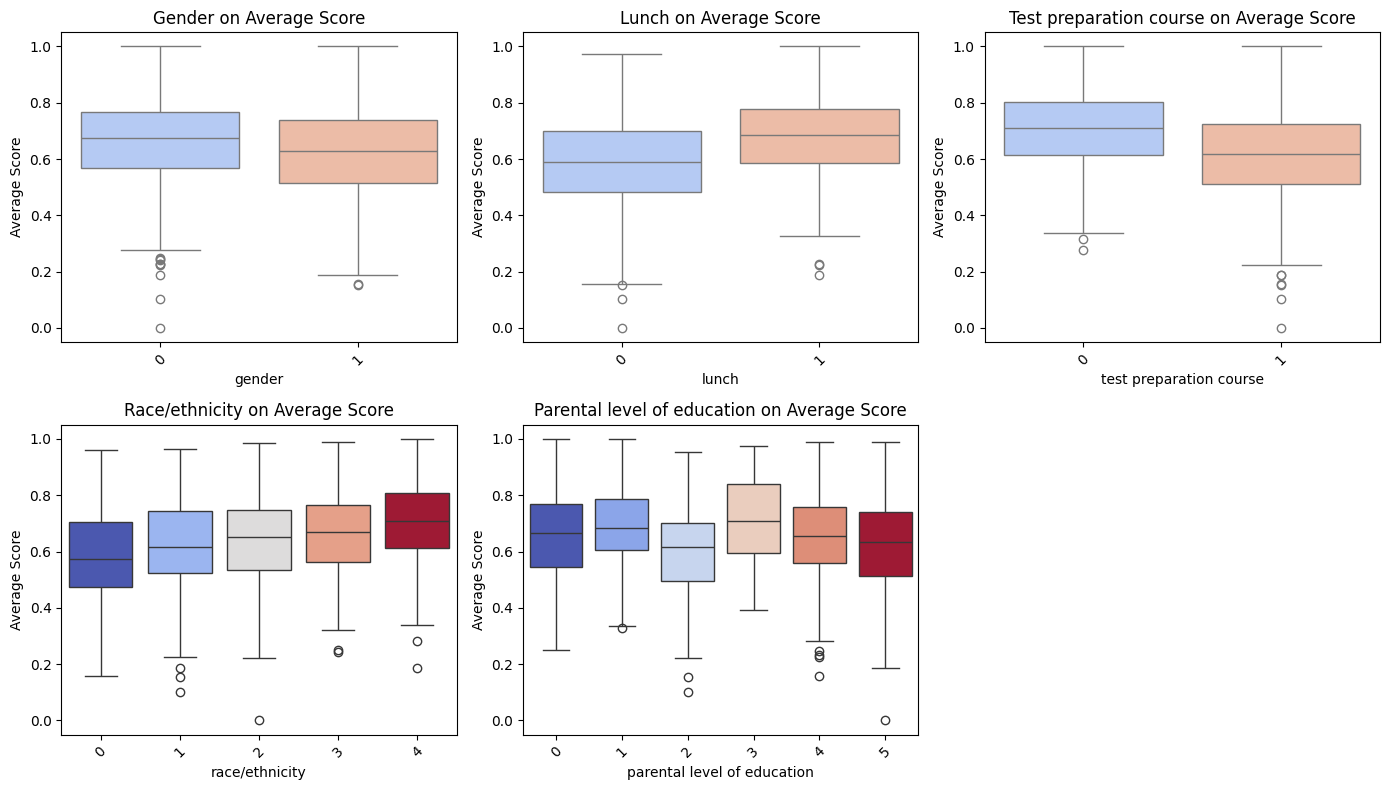

In [13]:
num_cols = 3  # 3 subplots per row
num_rows = (len(all_categorical_cols) + num_cols - 1) // num_cols  # Calculate required rows

# Create subplots
plt.figure(figsize=(14, 4 * num_rows))

for i, col in enumerate(all_categorical_cols, 1):  # Loop through all categorical columns
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=data[col], y=data['average_score'], hue=data[col], data=data, palette="coolwarm", legend=False)
    plt.title(f"{col.capitalize()} on Average Score")
    plt.xlabel(col)
    plt.ylabel("Average Score")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. The first boc plot show that the mean scores of male (1) and female (0) students are very close, indicating that there are no significant gender differences in overall academic performance. However, there are more low-end outliers in the female group, indicating that some female students have significantly lower scores than most students. This shows that while many female students perform well, some may have a harder time than male students.

2. The second box plot show that explores the effect of lunch type on mean score. Students who receive a standard lunch (1) tend to have higher mean scores than students who receive a free/reduced lunch (0). The lower score outliers among students who receive a free/reduced lunch indicate that some students in this category score significantly lower than the majority. This suggests that students who are unable to get adequate nutrition may face additional academic challenges.

3. The third box plot shows that the median for students who did not take the preparation course (0) is slightly higher than for those who did (1). There are more low and middle outliers in the preparation course group. This may indicates that some students still got relatively low scores even after taking the preparation course.

4. The fourth box plot show that the effect of race/ethnicity on the average score. Although the median scores of different racial/ethnic groups are slightly different, the median score of the group 4(Group E) is the highest, and the group 1(Group 1) is the lowest. Except for the first group, all other groups have outliers in the bottom segment. This indicates that in each of these categories, there are students who perform lower than expected. This indicates that there are differences in academic performance between different racial/ethnic groups.

5. The fifth boc plot show that the students whose parents have a master's degree (3) or college degree (4) tend to have slightly higher average scores than students whose parents only have a high school degree (2). However, the difference is not significant, which indicates that the educational level of parents has a limited impact on student achievement.

In [14]:
# Convert scaled average score back to 100-point scale for proper grading
data['performance_score'] = data['average_score'] * 100  

# Define performance categories based on average_score
def grade(avg):
    if avg >= 85:
        return 'Excellent'
    elif avg >= 70:
        return 'Good'
    elif avg >= 50:
        return 'Average'
    else:
        return 'Needs Improvement'

data['performance_level'] = data['average_score'] * 100  # Convert back to 0-100 scale
data['performance_level'] = data['performance_level'].apply(grade)

# Convert categorical performance levels to ordinal values
performance_mapping = {'Needs Improvement': 0, 'Average': 1, 'Good': 2, 'Excellent': 3}
data['performance_grade'] = data['performance_level'].map(performance_mapping)

# Normalize performance_grade to a continuous scale (0-1)
# scaler = MinMaxScaler()
# data[['performance_grade']] = scaler.fit_transform(data[['performance_grade']])

# Drop the categorical column
data.drop(columns=['performance_level','performance_score'], inplace=True)

# Display the updated dataset
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average_score,performance_grade
0,0,1,1,1,1,0.72,0.662651,0.711111,0.699634,1
1,0,2,4,1,0,0.69,0.879518,0.866667,0.805861,2
2,0,1,3,1,1,0.90,0.939759,0.922222,0.919414,3
3,1,0,0,0,1,0.47,0.481928,0.377778,0.443223,0
4,1,2,4,1,1,0.76,0.734940,0.722222,0.739927,2


We classified student performance into different levels based on their average scores. These transformations help improve the quality of the clustering results by ensuring that features contribute equally.

- Average score > 85 = Excellent, Performance Grade = 3
- Average score > 70 = Good, Performance Grade = 2
- Average score > 50 = Average, Performance Grade = 1
- Average score < 50 = Needs Improvement, Performance Grade = 0

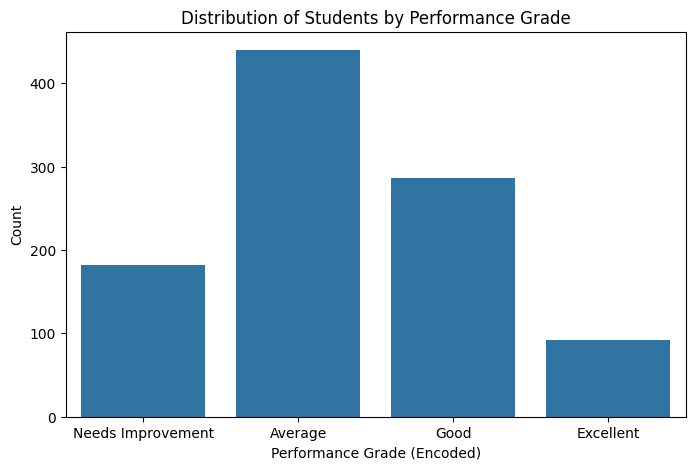

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data['performance_grade'])
plt.title("Distribution of Students by Performance Grade")
plt.xlabel("Performance Grade (Encoded)")
plt.ylabel("Count")
plt.xticks(ticks=[0,1,2,3], labels=["Needs Improvement", "Average", "Good", "Excellent"])
plt.show()

1. Needs improvement (average score <50, performance level = 0): About 200 students fall into this category. This indicates that a significant proportion of students are having academic difficulties and need additional support to improve their performance.

2. Average (Average score > 50, Performance Grade = 1): The largest group, with more than 400 students, was classified as average. This indicates that while many students met basic expectations, there is still room for improvement that could boost their performance to a higher level.

3. Good (Average score > 70, Performance Grade = 2): About 300 students achieved good results. This shows that a considerable proportion of students performed well above average.

4. Excellent (Average score > 85, Performance Grade = 3): The smallest group only around 100 students achieved an excellent level. This indicates that a small number of students have achieved the highest academic standards and demonstrated outstanding performance.

5. Most students perform at an average level, which indicates that educators need to focus on improving the performance of more students to the "good" and "excellent" levels.

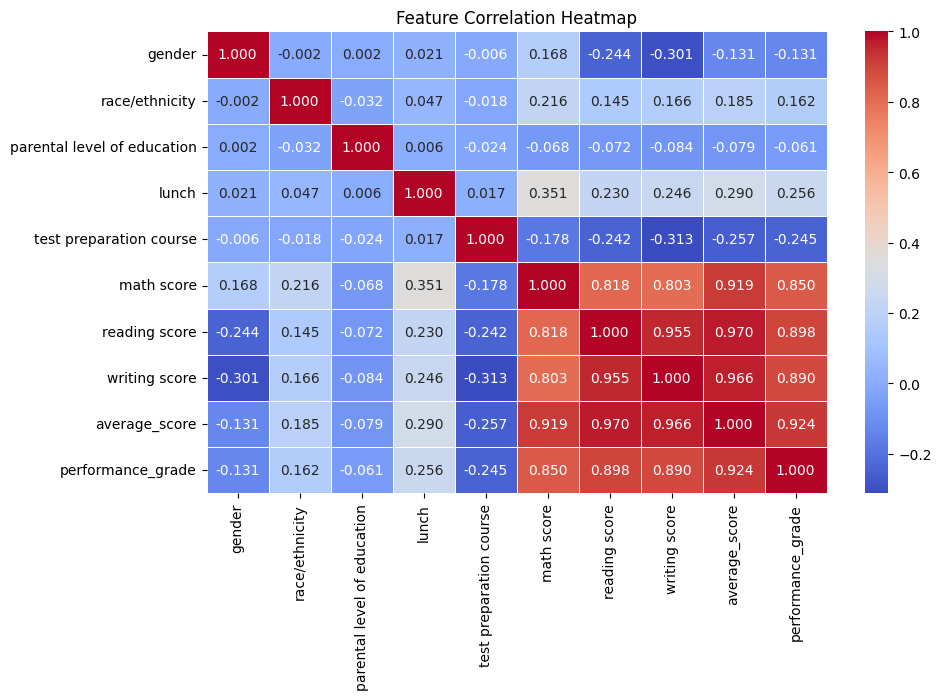

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Feature Correlation heatmap after added the new features which is average_score and performance_grade
1. The strong correlation between the average score and the grade (0.924) confirms that the grading system accurately reflects students' academic performance. The higher the average score, the higher the grade, so the grade is a reliable indicator of overall performance.

2. The correlation between the average score and each subject is also very strong. The scores for mathematics, reading and writing are all highly correlated with the average score, with reading and writing showing the strongest correlation. This shows that the average score can effectively summarize students' performance in all subjects.

3. The type of lunch was moderately positively correlated with the average score and grade level. Students who ate the standard lunch tended to have higher average scores, which further confirms the importance of nutrition for academic success.

4. However, the test preparation course was negatively correlated with the average score and grade level. This indicates that students who take the course may have academic difficulties, as the course did not significantly improve overall performance.

5. Gender was weakly negatively correlated with average scores and perfromance garde, meaning that scores tended to decrease slightly with increasing gender value. This indicates that one gender group performed slightly better overall than the other. Although the difference was small, it was consistent with the previous finding that differences in grades may be related to subject strengths.

# 4.0 PCA (Principal Component Analysis) for Dimensionality Reduction

Principal component analysis (PCA) was applied in this study to reduce the dimensionality of the dataset while retaining necessary information. The main motivation for using PCA was to address the high correlation between the numerical features, in particular 'math score', 'reading score', 'writing score', 'average score' and'grade level'. The correlation heatmap clearly shows that these features exhibit a strong positive correlation (close to 1.0), indicating that the redundancy does not significantly contribute to the clustering effect.

To solve this problem, we use principal component analysis to convert these correlated features into a smaller set of independent components. We perform two principal component analysis transformations:
1. PCA (PCA1_2, PCA2_2) consists of two components: for visualization, to present data in an interpretable two-dimensional form.
2. PCA (contains 4 components: PCA1, PCA2, PCA3, PCA4): used for modeling to retain more variables and improve clustering performance.

In [17]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define numerical columns for PCA
clustering_cols = ['math score', 'reading score', 'writing score', 'average_score', 'performance_grade']

# Apply Standard Scaling to standardize the features
scaler = StandardScaler()
data[clustering_cols] = scaler.fit_transform(data[clustering_cols])

# Apply PCA with 2 components (for visualization)
pca_2 = PCA(n_components=2)
pca_features_2 = pca_2.fit_transform(data[clustering_cols])

# Store 2-component PCA results separately for visualization
data[['PCA1_2', 'PCA2_2']] = pca_features_2

# Apply PCA with 4 components (for modeling)
pca_4 = PCA(n_components=4)
pca_features_4 = pca_4.fit_transform(data[clustering_cols])

# Store 4-component PCA results separately for modeling
data[['PCA1', 'PCA2', 'PCA3', 'PCA4']] = pca_features_4

# Display dataset after PCA transformation
data[['PCA1_2', 'PCA2_2', 'PCA1', 'PCA2', 'PCA3', 'PCA4']].head()

,PCA1_2,PCA2_2,PCA1,PCA2,PCA3,PCA4
0,0.442046,0.068508,0.442046,0.068508,-0.595558,-0.128139
1,2.155349,-0.917736,2.155349,-0.917736,-0.118496,0.122333
2,3.896454,-0.017383,3.896454,-0.017383,0.275619,0.076545
3,-2.884224,-0.079177,-2.884224,-0.079177,-0.210409,0.545654
4,1.400570,0.137590,1.400570,0.137590,0.220600,0.089853


Before PCA was applied, all numerical features were standardized using StandardScaler to ensure a unified scale. The components generated by PCA effectively captured the most critical variables in the student achievement data, resulting in more efficient and meaningful clustering in subsequent steps.

### PCA Visualization of Student Performance Data

In [18]:
# Print explained variance
print(f"Explained variance for 2 components: {sum(pca_2.explained_variance_ratio_):.4f}")
print(f"Explained variance for 4 components: {sum(pca_4.explained_variance_ratio_):.4f}")

Explained variance for 2 components: 0.9675
Explained variance for 4 components: 1.0000


Since the difference is very small, it is sufficient to use two components, which allows both visualization and cluster analysis while maintaining the simplicity and effectiveness of the dataset.

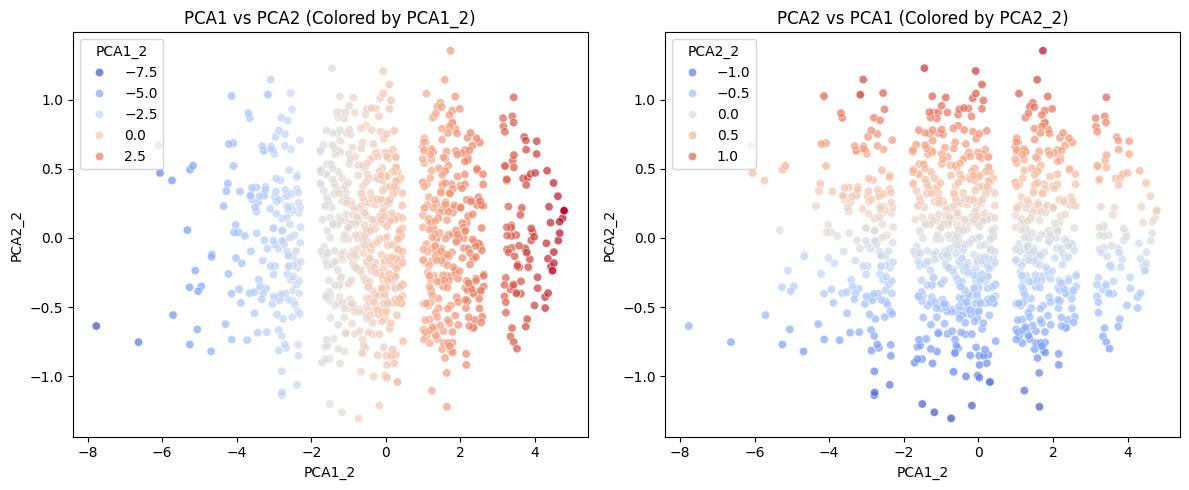

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA1 vs PCA2 (Color by PCA1)
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['PCA1_2'], 
                palette="coolwarm", alpha=0.7, ax=axes[0])
axes[0].set_title("PCA1 vs PCA2 (Colored by PCA1_2)")
axes[0].set_xlabel("PCA1_2")
axes[0].set_ylabel("PCA2_2")

# PCA1 vs PCA2 (Color by PCA2)
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['PCA2_2'], 
                palette="coolwarm", alpha=0.7, ax=axes[1])
axes[1].set_title("PCA2 vs PCA1 (Colored by PCA2_2)")
axes[1].set_xlabel("PCA1_2")
axes[1].set_ylabel("PCA2_2")

# Adjust layout and display
plt.tight_layout()
plt.show()

The two scatter plots represent student achievement data after a PCA transformation, but colored according to different principal components. The left plot is colored with PCA1_2 and the right plot with PCA2_2. By comparing the two plots, we can understand the contribution of each principal component to the data distribution.

**Left Plot (Colored by PCA1_2):**
1. The color gradient clearly transitions from left to right, with the leftmost point being blue (low PCA1_2 value) and the rightmost point being red (high PCA1_2 value).

2. PCA1_2 captures most of the variation in the data, as it shows a well-structured horizontal distribution.

**Right Plot (Colored by PCA2_2):**
1. The color gradient follows a vertical transition, with the lowest point being blue (low PCA2_2 value) and the highest point being red (high PCA2_2 value).

2. PCA2_2 has much less spread, indicating that this component captures less variance than PCA1_2.

PCA1_2 is the main component explaining the difference, as it shows a clear horizontal separation of the data points. PCA2_2 captures fewer differences, as can be seen from the weaker vertical separation, which means it has less of an effect on distinguishing between performance levels.

- PCA with 2 components → for visualization
- PCA with 4 components → for classification

### Train Classification Models on PCA Data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define X (features) and y (target)
X = data[['PCA1', 'PCA2', 'PCA3', 'PCA4']]  # Use PCA 4D for classification
y = data['gender']  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)

# Train Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Compare model accuracy
model_results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest"],
    "Accuracy": [acc_log_reg, acc_svm, acc_rf]
})

print("Classification Accuracy Comparison:")
print(model_results)

Classification Accuracy Comparison:
                 Model  Accuracy
0  Logistic Regression     0.900
1                  SVM     0.915
2        Random Forest     0.885


# 5.0 K-Means Clustering on PCA Data

The focus of this step is to determine the optimal number of clusters (k) in the K-Means clustering method, using two commonly used evaluation methods:
- The elbow method – based on the within-cluster sum of squares (WCSS)
- The silhouette score – based on cluster separation and cohesion

## Determine optimal k using Elbow Method

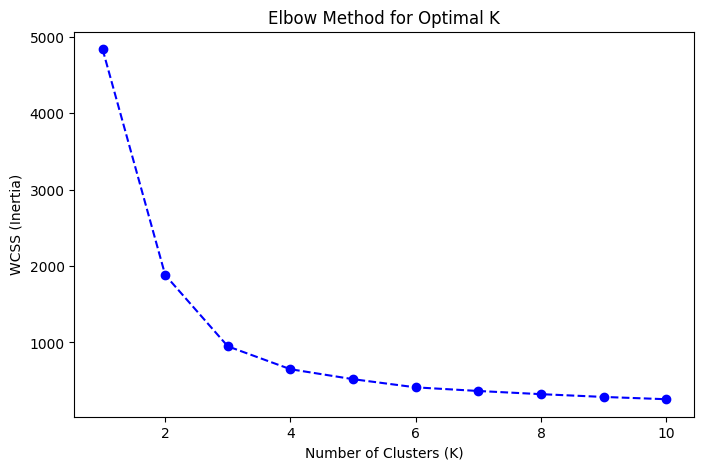

Optimal k based on Elbow Method: 3


In [21]:
# Define the selected features for clustering
cluster_cols = ['PCA1_2', 'PCA2_2']

inertia = []
k_values = range(1, 11)
for k in k_values:
    # kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data[cluster_cols])
    inertia.append(kmeans.inertia_) # Store WCSS for each K

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()

optimal_k_elbow = KneeLocator(k_values, inertia, curve='convex', direction='decreasing').elbow
print(f"Optimal k based on Elbow Method: {optimal_k_elbow}")

**Based on the plot of Elbow method, we can know that:**

- Between K=1 and K=3, the curve shows a clear downward trend, after which the downward trend gradually slows down.
- At K=3, the curve reaches an inflection point and the rate of decrease slows.
- This indicates that **K=3** is the optimal number of clusters, because increasing the number of clusters after this point does not lead to a significant increase in compactness.

## Determine optimal k using Silhouette Scores

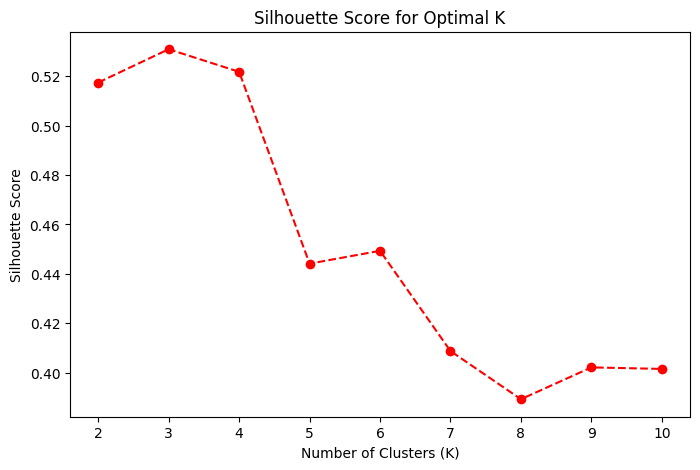

Optimal k based on Silhouette Score: 3


In [22]:
silhouette_scores = []  # Stores silhouette scores for different K
k_values = range(2, 11)  # Define k_values to avoid NameError

for k in k_values:  # Avoid K=1 (Silhouette Score requires at least 2 clusters)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data[['PCA1_2', 'PCA2_2']])
    silhouette_scores.append(silhouette_score(data[['PCA1_2', 'PCA2_2']], labels))

# Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()

# Correct the variable name
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Optimal k based on Silhouette Score: {optimal_k_silhouette}")

**Based on the plot of Silhouette Score, we can know that:**

- The silhouette score is highest for K=3 (approximately 0.53), which means that this is the optimal clustering structure based on the similarity within clusters.
- The score drops significantly for K>4, indicating that increasing the number of clusters reduces the clustering quality.
- This supports the elbow method's view that **K=3** is the optimal value, as it balances compact and well-separated clusters.

## Compare value within two optimal approach

In [23]:
# Comparing k options for evaluation
k_options = [optimal_k_elbow, optimal_k_silhouette]
comparison_results = {}
for k in k_options:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(data[numerical_cols])
    silhouette = silhouette_score(data[numerical_cols], labels)
    wcss = inertia[k - 1]
    comparison_results[k] = {'Silhouette Score': silhouette, 'WCSS': wcss}

# Display comparison table
display(pd.DataFrame(comparison_results).T)

,Silhouette Score,WCSS
3,0.427113,949.541908


- Both elbow method and silhouette scores confirm that K=3 is the optimal number of clusters.
- K-Means is applied to the PCA-reduced data set (PCA1_2, PCA2_2) with three clusters.

## Apply K-Means on PCA Data with optimal K=3

After determining that **K=3** is the optimal number of clusters using the elbow method and silhouette score, we used the K-means clustering method to cluster the data after PCA reduction. This step helps to assess whether PCA helps to produce meaningful clusters.

Using the two principal components (PCA1_2 and PCA2_2), the K-means clustering method, based on K=3, divides the students into three groups according to their performance. The resulting diagram visually displays these groups in the PCA-transformed space.

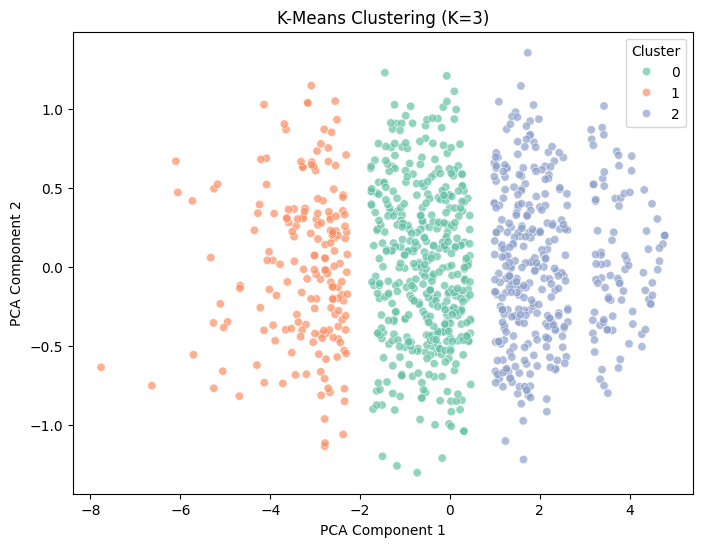

In [24]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['cluster_k3'] = kmeans.fit_predict(data[['PCA1_2', 'PCA2_2']])

# Visualize Clusters for K=3
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['cluster_k3'], palette="Set2", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering (K=3)")
plt.legend(title="Cluster")
plt.show()

**Based on this scatter plot, we can observe that:**

- The scatter plot clearly shows three well-separated clusters, indicating that PCA has retained meaningful variations in student performance.
  
- The K-Means successfully classifies students into three different performance levels. This confirms that PCA improves clustering performance by simplifying the data structure. The transformed components help reveal clearer patterns in the data set.

**Cluster interpretation:**
- Cluster 0 (leftmost group): represents students with lower performance
- Cluster 1 (middle group): represents students with moderate performance
- Cluster 2 (rightmost group): represents students with higher performance

The results show that PCA effectively reduces the redundant information in the dataset while retaining the key variables. By transforming highly correlated features into principal components, PCA enables K-Means to cluster the data more effectively.

### Analyze Cluster Characteristics

To better understand the characteristics of each group, we calculated the mean value of each group's main academic achievement indicators, including math, reading, and writing scores. The analysis revealed clear differences between the groups.

In [25]:
# Compute mean values for each cluster (K=3) to understand cluster characteristics
cluster_analysis_k3 = data.groupby('cluster_k3')[['math score', 'reading score', 'writing score', 'average_score', 'performance_grade']].mean()
cluster_analysis_k3

,math score,reading score,writing score,average_score,performance_grade
cluster_k3,,,,,
0,-0.217167,-0.238653,-0.209010,-0.232707,-0.331878
1,-1.369393,-1.444614,-1.462915,-1.498313,-1.484233
2,0.912124,0.973352,0.947658,0.992286,1.100944


1. The cluster 0 students includes all students with the lowest scores in all subjects, indicating that this group of students may need additional academic support.
2. The cluster 1 students includes students with average grades, who performed near the average in all three subjects.
3. The cluster 2 students includes the highest-scoring students, who scored significantly higher in math, reading, and writing.

### Extract cluster centroids and labels for K=3

Next, we analyze the characteristics of each cluster created by K-Means. The cluster centroids represent the average position of all points in a group, based on the PCA-transformed data. These centroids help us understand the key differences between the clusters.

In [26]:
labels_k3 = kmeans.labels_
centroids_k3 = kmeans.cluster_centers_

# Convert centroids into DataFrame
centroids_df_k3 = pd.DataFrame(centroids_k3, columns=['PCA1', 'PCA2'])

# Display centroids
print("Cluster Centroids for K=3")
print(" ")
print(centroids_df_k3)

# Detailed cluster analysis for K=3
for i in range(kmeans.n_clusters):
    cluster_points = data.loc[data['cluster_k3'] == i, ['math score', 'reading score', 'writing score']].values
    print(f"\nCluster {i}:")
    print(f"Number of Points: {len(cluster_points)}")
    print(f"Centroid: {centroids_k3[i]}")
    print(f"Mean Math Score: {np.mean(cluster_points[:, 0]):.2f}")
    print(f"Mean Reading Score: {np.mean(cluster_points[:, 1]):.2f}")
    print(f"Mean Writing Score: {np.mean(cluster_points[:, 2]):.2f}")


Cluster Centroids for K=3
 
       PCA1      PCA2
0 -0.549560 -0.008616
1 -3.247679  0.003945
2  2.203397  0.008129

Cluster 0:
Number of Points: 440
Centroid: [-0.54956004 -0.00861551]
Mean Math Score: -0.22
Mean Reading Score: -0.24
Mean Writing Score: -0.21

Cluster 1:
Number of Points: 182
Centroid: [-3.24767856  0.00394497]
Mean Math Score: -1.37
Mean Reading Score: -1.44
Mean Writing Score: -1.46

Cluster 2:
Number of Points: 378
Centroid: [2.2033966 0.0081292]
Mean Math Score: 0.91
Mean Reading Score: 0.97
Mean Writing Score: 0.95


**Overall Cluster Distribution:**

1. The clustering process has successfully separated students into three distinct performance levels: high performers (Cluster 2), lower performers (Cluster 0), and moderate performers (Cluster 1).

2. PCA1 played a dominant role in distinguishing these groups, as its values varied significantly between clusters, effectively separating them. In contrast, PCA2 values remained close to zero with minimal variation, indicating that it had little impact on differentiating the groups.

3. The largest group of students belongs to category 0 (lower performance), followed by category 2 (higher performance), then category 1 (moderate  performance), with category 1 students being the smallest group.

This confirms that K-Means effectively categorized students based on their academic performance. These insights suggest that underachieving students (cluster 0) may need additional academic support, while high-achieving students (cluster 2) could benefit from advanced learning opportunities.

### Visualize Cluster Centers for K=3

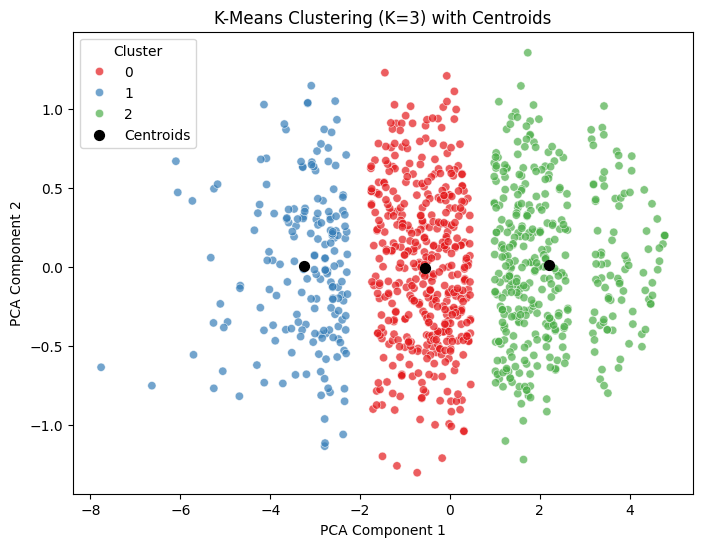

In [27]:
# Extract cluster centroids
centroids_k3 = kmeans.cluster_centers_

# Plot clusters with centroids
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['cluster_k3'], palette="Set1", alpha=0.7)
plt.scatter(centroids_k3[:, 0], centroids_k3[:, 1], marker='o', s=50, color='black', label='Centroids')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering (K=3) with Centroids")
plt.legend(title="Cluster")
plt.show()

### Distribution of Students Across Clusters

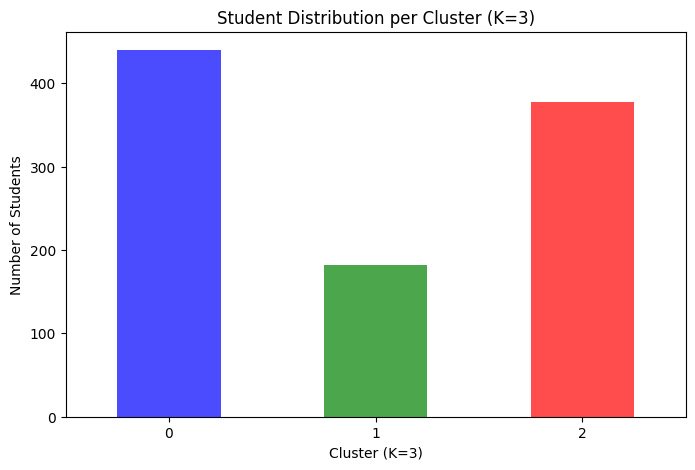

In [28]:
# Count the number of students in each cluster for K=3
cluster_distribution_k3 = data['cluster_k3'].value_counts().sort_index()

# Create a DataFrame for better visualization
cluster_dist_df = pd.DataFrame({'K=3 Cluster Count': cluster_distribution_k3})

# Plot the student distribution for K=3
plt.figure(figsize=(8, 5))
cluster_distribution_k3.plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.7)
plt.xlabel("Cluster (K=3)")
plt.ylabel("Number of Students")
plt.title("Student Distribution per Cluster (K=3)")
plt.xticks(rotation=0)
plt.show()

Based on this plot, we can observe that:

1. Cluster 0 (blue) is the largest group and represents the lower achievers. There are over 400 students in this group, which indicates that a significant proportion of students fall into the lower achiever category, meaning they may require additional academic support or intervention.

2. Cluster 3 (green), which is the smallest, represents students with average grades. There are less than 200 students in this group, indicating that there are relatively few students with average grades, and most students either have poor grades or excellent grades.

3. Cluster 2 (red) is the second-largest group, representing higher-performing students. There are about 350 students in this group, which shows that a considerable number of students are doing well academically and are between the first and third groups.

###  Percentage of Students in each Cluster

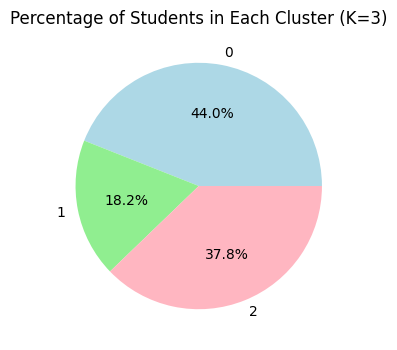

In [29]:
total_students = len(data)
clus_percentages = (cluster_distribution_k3 / total_students) * 100

# Create a DataFrame for better visualization
cluster_summary = pd.DataFrame({'Cluster': cluster_distribution_k3.index, 
                                'Cluster Size': cluster_distribution_k3.values, 
                                'Percentage (%)': clus_percentages.values})

plt.figure(figsize=(6, 4))
plt.pie(clus_percentages, labels=cluster_distribution_k3.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightpink'])
plt.title("Percentage of Students in Each Cluster (K=3)")
plt.show()

The pie chart shows the percentage distribution of the three identified student groups. Cluster 0 represents the lower level and has the highest proportion, 44.0%, followed by cluster 2, the higher level group, with 37.8%. Cluster 1 includes students at the moderate level and has the smallest proportion, 18.2%.

### Compare K-Means with Agglomerative Clustering & DBSCAN

In this step, we compare K-Means, Cluster Clustering, and DBSCAN to evaluate their effectiveness in clustering student achievement data. The goal is to determine whether K-Means is the most appropriate clustering method for this data set.

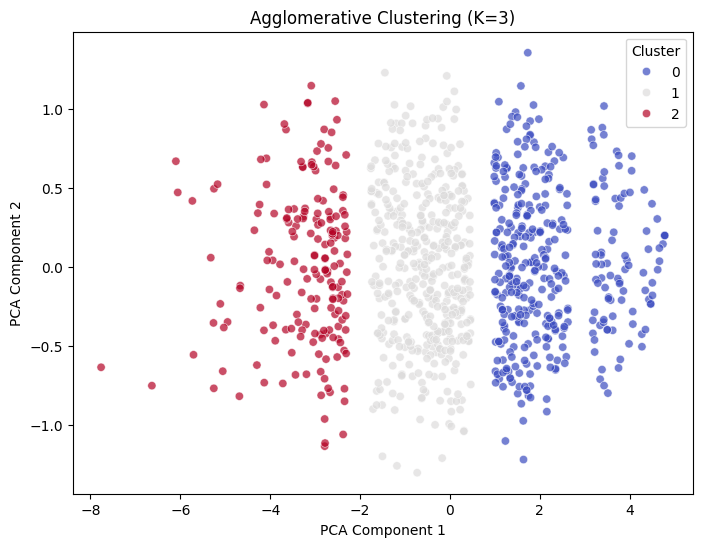

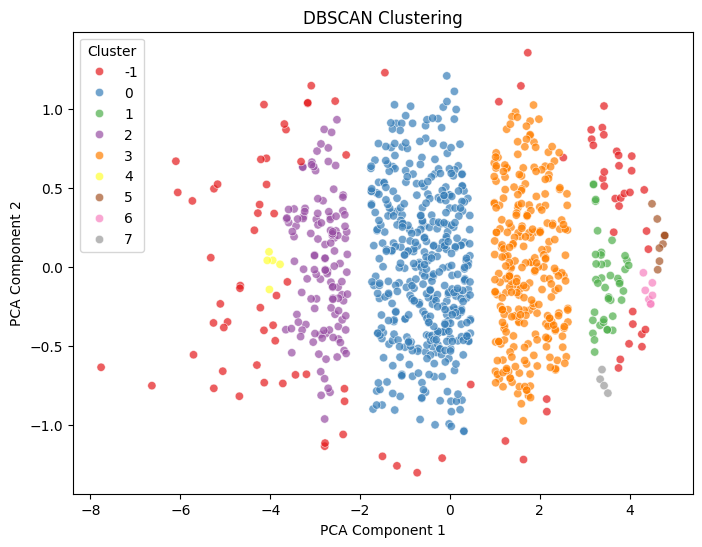

,cluster_k3,agg_cluster,dbscan_cluster
0,0,1,0
1,2,0,-1
2,2,0,1
3,1,2,2
4,2,0,3


In [30]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Apply Agglomerative Clustering (Same number of clusters as K-Means for fair comparison)
agg_clustering = AgglomerativeClustering(n_clusters=3)
data['agg_cluster'] = agg_clustering.fit_predict(data[['PCA1_2', 'PCA2_2']])

# Apply DBSCAN (Density-Based Clustering)
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Parameters may need tuning
data['dbscan_cluster'] = dbscan.fit_predict(data[['PCA1_2', 'PCA2_2']])

# Visualize Agglomerative Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['agg_cluster'], palette="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering (K=3)")
plt.legend(title="Cluster")
plt.show()

# Visualize DBSCAN Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['PCA1_2'], y=data['PCA2_2'], hue=data['dbscan_cluster'], palette="Set1", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering")
plt.legend(title="Cluster")
plt.show()

# Display cluster assignments for K-Means, Agglomerative, and DBSCAN in a readable format
data[['cluster_k3', 'agg_cluster', 'dbscan_cluster']].head()

Based on the comparison of K-Means, Cluster Clustering and DBSCAN, K-Means seems to be the most appropriate clustering method for this dataset. The K-Means clustering results show clearly separated clusters with clear boundaries, effectively grouping students according to their performance. Cluster clustering provides a similar structure, but the cluster assignments are slightly different, which may indicate sensitivity to stratification merging decisions. On the other hand, DBSCAN identifies multiple small clusters and noise points (labelled -1), which indicates that it is not suitable for this dataset because it has difficulty forming meaningful groups. The results show that K-Means can distinguish between student achievement levels while maintaining well-defined clusters.

## Comparison of Clustering Methods (K-Means, Agglomerative Clustering, and DBSCAN)

To determine the clustering method that is best suited to this dataset, we compared K-means, agglomerative clustering and DBSCAN using silhouette scores. Silhouette scores measure the degree of match between data points and the cluster to which they belong. The higher the score, the clearer and more distinct the clusters.

               Silhouette Score
K-Means                0.530852
Agglomerative          0.530852
DBSCAN                 0.430929
 


<Figure size 600x400 with 0 Axes>

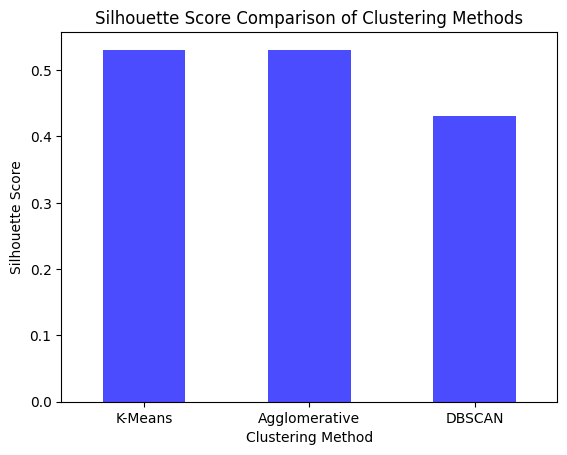

In [31]:
clustering_methods = {
    "K-Means": data['cluster_k3'],
    "Agglomerative": data['agg_cluster'],
    "DBSCAN": data['dbscan_cluster']
}

# Evaluate Silhouette Scores for each clustering method
silhouette_scores = {}
for method, labels in clustering_methods.items():
    # Exclude DBSCAN's noise points (-1) from silhouette score calculation
    if method == "DBSCAN":
        mask = labels != -1
        score = silhouette_score(data.loc[mask, ['PCA1_2', 'PCA2_2']], labels[mask])
    else:
        score = silhouette_score(data[['PCA1_2', 'PCA2_2']], labels)
    
    silhouette_scores[method] = score

# Convert to DataFrame for better visualization
silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['Silhouette Score'])

# Display silhouette scores
print(silhouette_df)
print(" ")

# Plot Silhouette Scores
plt.figure(figsize=(6, 4))
silhouette_df.plot(kind='bar', legend=False, color=['blue', 'green', 'red'], alpha=0.7)
plt.title("Silhouette Score Comparison of Clustering Methods")
plt.xlabel("Clustering Method")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=0)
plt.show()

1. K-Means and Agglomerative Clustering perform equally well:
Both obtained the highest Silhouette Score (0.530852), which means that the clusters are separated and compact. This shows that both methods can effectively group students into meaningful categories.

2. DBSCAN performs the worst (0.430929):
DBSCAN produces many small and scattered clusters. The lower silhouette score indicates a weak cluster structure, which means that some points are not assigned properly.

Although K-Means and the Agglomerative Clustering have comparable results, K-Means is more computationally efficient and is better suited to handle larger datasets. Therefore, for clustering tasks where scalability and efficiency are important factors, K-Means is a more practical choice. 

# Conclusion

The optimization of this laboratory successfully optimized K-Means clustering by reducing the dimension through principal component analysis (PCA) integration. The explained variance ratio (96.75%) shows that PCA effectively retains most of the information in the original dataset while reducing feature redundancy. The elbow method and silhouette scores confirm that K=3 is the optimal number of clusters for this dataset.

After applying K-Means clustering to the PCA-transformed data, the clusters were well separated and represented low, medium and high-performing students respectively. The silhouette score comparison showed that K-Means and Cluster had similar performances, while DBSCAN had difficulty with the dataset structure, resulting in a lower silhouette score.

Overall, the results confirm that K-Means is an effective and computationally efficient method for classifying students based on grades. The PCA transformation helps to improve the quality of the clusters, making K-Means the best choice for this dataset.

## Methodologies
- K-Means: Assigns points to the nearest cluster centroid.
- Agglomerative Clustering: Hierarchical method that merges points iteratively.
- DBSCAN: Density-based clustering that identifies core and noise points.
- Silhouette Score Calculation:
- For DBSCAN, we excluded noise points (-1) from the silhouette score calculation to avoid skewing results.

## References

1. ML_Lab04_KMeans_241119
2. https://www.kaggle.com/datasets/jagdishchavan/student-performance
3. https://www.kaggle.com/code/realstay/clustering-with-silhouette-plot-elbow-method
4. https://github.com/rhasanbd/Clustering-K-Means-All-You-Care-About/tree/master
5. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
6. https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/